# Introduction to Neural Networks

Written by Rikab Gambhir (Center for Theoretical Physics, MIT)

In this tutorial, we will explore Neural Networks, the fundamental building block of deep learning. We will go into the very basics of the theory of Neural Networks and Universal Function Approximation. Then, we will explore practical immplementations of Neural Networks and deep learning that are widely used both in physics applications and also are widespread in industry.

This tutorial is divided into 4 parts:



1.   **Neural Network Basics**: Constructing multi-layer perceptrons and studying universal function approximation.
2.   **JAX**: An increasingly popular library used for machine learning. This library is extremeley similar to basic numpy, but has extra features like autodifferentiation and compilation that make it useful for machine learning.
3.   **PyTorch**: A commonly used ML library. Developed by Meta. Especially nice for implementing fancy modern ML models, since they're mostly developed in PyTorch anyways!
4.   **Tensorflow**: Less common in 2025, but many ML tools still use it.





**Prerequisites**

I will assume knowledge of the following:
1. Basic python and numpy. You should be comfortable with matrix operations within numpy, dealing with lists and loops, defining functions, and classes.
2. You are familiar with the previous tutorials on regression, classification, normalizing flows, and unsupervised learning. In particular you should appreciate the idea of finding parameters that minimize the log-likelhood (or other metrics) for function fitting, and the general importance of finding/optimizing for functions for statistical tasks.

# Chapter 1: Neural Network Basics

In [15]:
# Standard Imports
import os
import sys
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In previous tutorials, e.g. [regression](https://colab.research.google.com/github/mcgen-ct/tutorials/blob/main/ml/regression.ipynb), the goal was to model a fixed functional form $f(x)$ where $f$ depended on some parameters $\theta$. For example, a linear fit of the form $f(x) = \theta_0 + \theta_1 x$.

In Deep Learning, we want to be more ambitious. We do not want to assume a specific fucntional form: rather than only ``searching'' over linear functions, we want to search over *all* functions, or at least a very large class of functions. Our strategy for doing this is to take a functional form with an extremeley large set of parameters, such that in the infinite parameter limit all functions of a particular class fit within the parameterization. For example. the set of functions:

\begin{align}
f(x) = \sum_{i=0}^N \theta_i x^i
\end{align}

models all one-dimension analytic functions as $N \to \infty$. However, we would like a more general parameterization that can work for many dimensions and even model non-smooth (or even non-continuous) functions arbtirarily well.

A **Neural Network (NN)**  (also known as a **Multilayer Perceptron (MLP)** a **feedforward network**, or a **Dense Neural Network (DNN)** depending on the context) parameterizes *all* peicewise-continuous functions from $\mathbb{R}^{n} \to \mathbb{R}^m$ arbitrarily well with a very simple parameterization.


To define a neural network, we first specify $L-2$ integers $N_1, ..., N_{L-1}$. Just for notation, choose $N_0 = n$ as the input dimension, and $N_L = m$ as the output dimension. $L$ is referred to as the *depth* of the network (or number of layers), and the $N$'s are the *width* of each layer. Unless you are doing something fancy (e.g. autoencoders), it is typical to choose $N$ to all be the same.

Then, we define a set of *layer functions*, which are maps $f^{\ell}:\mathbb{R}^{N_{\ell-1}}\to\mathbb{R}^{N_{\ell}}$, as:

$$ f^{\ell}(x) = \sigma(W^{(\ell)}x + b^{(\ell)})$$

where $W^{(\ell)} \in \mathbb{R}^{N_{\ell} \times N_{\ell -1}}$ and $b^{(\ell)} \in \mathbb{R}^{N_{\ell}}$ are the parameters that define the layer, and $\sigma$ is some pre-determined nonlinear transformation. This can differ between layers, but it is common to chose $\sigma$ to be the same for every layer except the last, where $\sigma$ is often instead chosen such that its image matches the desired output space. An extremeley common and simple chose for $\sigma$ is the ReLU (Rectified Linear Unit) function, which we will use throuhout the rest of this tutorial:

$$ \sigma(x) = \max(0, x)$$

Then, the full neural network is defined by:

$$ f = f^{L} \cdot f^{L-1} \cdot ... \cdot f^{1}$$

Let's make an MLP from scratch!

In [ ]:

# Building a Neural Network from Scratch #

input_dim = 2
output_dim = 1


L = 3
N = 16 # We will use the same N throughout for simplicity


# Function to initialize the W's and b's
# For now, lets just pick random numbers!
def init_params(input_dim, output_dim, L, N):

  Ws = []
  bs = []

  for l in range(L):
    if l == 0:
      W = np.random.randn(N, input_dim) / np.sqrt(input_dim)
      b = np.random.randn(N) / np.sqrt(input_dim)
      # The sqrt(input_dim) normalization is not important for our toy examples, but it is common to do for stability reasons

    elif l == L-1:
      W = np.random.randn(output_dim, N) / np.sqrt(N)
      b = np.random.randn(output_dim) / np.sqrt(N)

    else:
      W = np.random.randn(N, N) / np.sqrt(N)
      b = np.random.randn(N) / np.sqrt(N)

    Ws.append(W)
    bs.append(b)

  return Ws, bs

# Implement the ReLU function
def sigma(x):

  return np.maximum(0, x)


In [ ]:

# Function to evaluate a neural network given x, the weights W, and the biases b

def MLP(x, Ws, bs):

  y = x.copy()

  for l in range(L):

    # Fun python fact: "@" implements matrix multiplication!
    y = Ws[l] @ y + bs[l]

    # Don't apply sigma to the final output so that our answer isn't forced positive
    if l != L - 1:
      y = sigma(y)

  return y

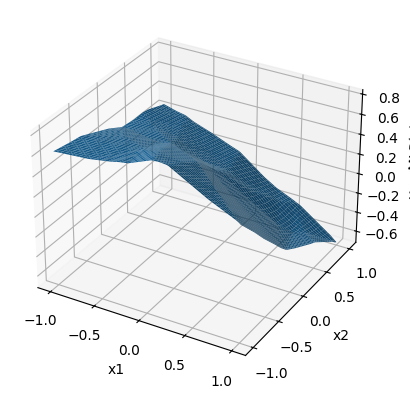

In [ ]:
# Test our MLP function by graphing the function f:R2 -> R1

# Define some test points in R2
xs1 = np.linspace(-1, 1, 100)
xs2 = np.linspace(-1, 1, 100)

xs1, xs2 = np.meshgrid(xs1, xs2)

# Initialize the weights and biases
Ws, bs = init_params(input_dim, output_dim, L, N)

ys = []
for x in zip(xs1.flatten(), xs2.flatten()):
  x = np.array(x)
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)
ys = ys.reshape(xs1.shape)

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs1, xs2, ys)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y = MLP(x)')
plt.show()





**A note on functional vs. object-oriented programming**

In the above code, we defined our MLP purely using python functions. There is no neural network "object" with an internal state keeping track of the parameters. Instead, the parameters $W$ and $b$ are also treated as inputs to functions. This is *functional programming*, in which there are no objects with internal states that get modified. This is the approach to ML used by JAX.

It is also possible to define an MLP *class*, which is an object that contains the parameters as internal states that can potentially be modified, and methods that implement the model and evaluate $f(x)$. This is the approach to ML used by PyTorch and Tensorflow.

It is largely a matter of programming taste which you prefer. Below, we will see a brief example of the above code, but written in an object-oriented style rather than functional.

In [ ]:
class My_MLP_Class():

  def __init__(self, input_dim, output_dim, L, N):

    # Initialize the network arguments
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.L = L
    self.N = N

    # Initialize the network internal state using the same initi function
    self.Ws, self.bs = init_params(input_dim, output_dim, L, N)

  def evaluate(self, x):

    # Just use the same exact function as above
    return MLP(x, self.Ws, self.bs)

  # "Magic Method" that lets us call the class as if it were a function (just syntatic magic)
  def __call__(self, x):

    return self.evaluate(x)


my_MLP = My_MLP_Class(input_dim, output_dim, L, N)

# Access the weights
my_weights = my_MLP.Ws
print("The number of layers is ",len(my_weights), ",Expected 3")

# Evaluate the function
print("f(1,1) = ", my_MLP(np.array([1, 1])))


The number of layers is  3 ,Expected 3
f(1,1) =  [-1.48328956]


**Historical Notes and Semantics**

The case where $L = 2$ (no ``hidden layers'' between the input and output) with the output dimensionality is $1$ is called a perceptron historically. These were introduced with $\sigma$ not as ReLU, but rather:
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$
(the sigmoid function, hence the notation), and were used back in the day as a model of a biological neuron. The neuron "activates" (produces $1$) when $x$ is large, and "deactivates" (produces $0$ when $x$ is small, where $b$ is then a bias. For this reason, $\sigma$ is called an activation function. This is also why our models are called "Neural Networks". The "network" is because the parameters of the weight matrix $w_{ij}$ are drawn as lines connecting a node $i$ in the previous layer to a node $j$ in the next layer. It's important to remember though, that these are just affine transformations interleaved by some simple nonlinear functions, and there isn't really anything magic here, just slightly-nonlinear algebra.

The name "feedforward" network just refers to the function-compositional aspect of the model. It is to be contrasted with a "backwards pass", where derivatives with respect to the network are actually computed in reverse-order due to chain-rule simplifications. The name "dense" neural network is to emphasize that this is the simplest possible network one can build. There are many modern models with additional properties (such as gauranteeing symmetries, or working in spaces other than simple vector spaces, or deliberately constraining the function space), but many of these can be reduced to very large MLPs with constrained weights. When we say "dense" or "fully-conencted" MLPs, we typically mean there are no constraints on the parameters.



## Chapter 1.1: Universal Function Approximation

The power of MLPs is that they are an efficient way to parameterize a large class of functions. This is captured by the **Universal Function Approximation Theorem(s) (UFAT)** (there are lots of variants, but at the level of rigor we are working at, we won't worry about this).

**Emotionally**, the UFAT tells us that for sufficiently large $N$ and $L$, an MLP can approximate any (reasonable) $n$-to-$m$ dimensional function arbitrarily well.

**Slightly more precisely**, a version of UFAT says: For any piecewise-continuous function $f: \mathbb{R}^n \to \mathbb{R}^m$ defined on a compact domain $D \subset \mathbb{R}^n$, and for any "error tolerance" $\epsilon  > 0$, there exists a large enough $N$ and $L$ such that one can define an MLP with specially-chosen parameters $W$ and $b$ such that:
$$ \int_D dx |f(x) - MLP(x)| < \epsilon $$
i.e. that we have approximated the function to within the specified error.

[Side note: It is actually always possible to do this with just $L$ = 3 (meaning just one hidden layer with chosen $N$ in our defined $L$ counting), but typically this requires an exponentially large $N$ and isn't of practical use for what we will be doing].


We will not prove the UFAT. However, we will explore a weaker-version of it that is easier to understand: If instead we explore continuous-and-piecewise-once-differentiable functions rather than just piecewise-continuous, then there is an easy construction using ReLU networks. If a function is piecewise-once-differentiable, then it can be well-approximated by a piecewise-linear function. We will see below (as exercises) how ReLU networks can exactly reproduce piecewise linear functions.

###START_EXERCISE

#### EXERCISE: Modeling |x|

Given $f(x) = |x|$ in 1 dimension, design an MLP with a choice of N, L, weights W, and biases b that *exactly* match $f(x)$.

HINT: It is possible to do this with $L = 2$ (one hidden layer) and $N = 2$.

HINT 2: It is possible to do this with $b = 0$.



In [ ]:
def f(x):
  return np.abs(x)


L = # YOUR SOLUTION HERE
N = # YOUR SOLUTION HERE

Ws = [] # YOUR SOLUTION HERE
bs = [] # YOUR SOLUTION HERE

xs = np.linspace(-1, 1, 100)

# Evaluate the solution
ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)

# Plot
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


###STOP_EXERCISE

###START_SOLUTION

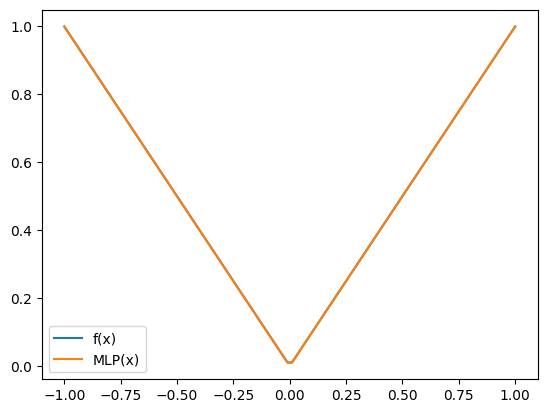

In [ ]:
def f(x):
  return np.abs(x)


L = 2
N = 2

W0 = np.array([[ 1.0],      # hidden unit 1:  +x
               [-1.0]])     # hidden unit 2:  –x
b0 = np.array([0.0, 0.0])   # no shift

W1 = np.array([[1.0, 1.0]]) # add the two ReLU outputs
b1 = np.array([0.0,])        # no shift

Ws = [W0, W1]
bs = [b0, b1]

xs = np.linspace(-1, 1, 100)

# Evaluate the solution
ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)

# Plot
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


###STOP_SOLUTION

###START_EXERCISE

EXERCISE: Approximating a smooth 1D function.

Given $f(x) = \sin(10x) \exp(-2x^2)$ on the interval $[-1,1]$, design an MLP with ReLU-activations that approximates the function to within an error of $\epsilon < 0.01$ (where error is the mean-absolute error, as defined above). As a bonus, your implementation should be systematically improvable, e.g. it should be straightforward to make the MLP bigger to reduce the error further. Don't cheat and use minimization to get the parameters, explicitly construct them!


HINT: First construct a continuous piecewise linear appoximation to the function, then implement this piecewise linear function as an MLP. It is possible to do this without knowledge of the actual form of $f$.

HINT 2: This is possible to do systematically with $L = 2$ as before, but with a very large $N$. My personal solution requires $N$ between 100 and 150.

HINT 3: A peicewise-linear continuous function can be written as $f(x) = c_0 + m_0x + + \sum_{j = 1}^{n-1}(m_j - m_{j-1})\sigma(x - x_j)$, where $\sigma$ is ReLU, $x_{1}...x_{n-1}$ are the internal breakpoints, $m_j$ are the slopes to the right of each breakpoint, and $c_0$ is the $y$-coordinate at the leftmost point.




In [ ]:
def f(x):
  return np.sin(10*x) * np.exp(-2*x**2)

L = # YOUR SOLUTION HERE
N = # YOUR SOLUTION HERE
Ws = [] # YOUR SOLUTION HERE (hint, define a function to construct Ws, bs, systematically)
bs = [] # YOUR SOLUTION HERE


xs = np.linspace(-1, 1, 1000)

ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))
ys = np.array(ys)

plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()

# Approximate the mean absolute error
print("Mean absolute error: ", np.mean(np.abs(ys[:,0] - f(xs)))) #[:,0] due to annoying indexing


###STOP_EXERCISE

###START_SOLUTION

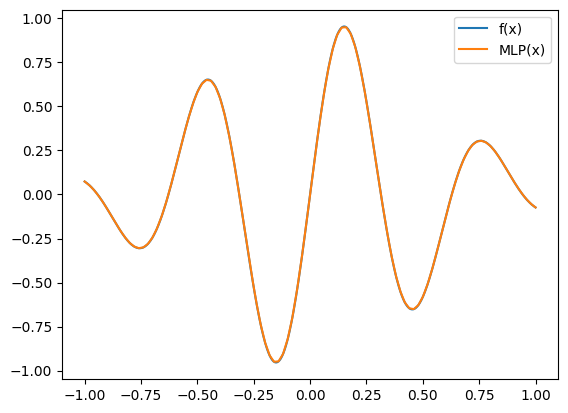

Mean absolute error:  0.0013505212831013116


In [ ]:

# For any function f, define a piecewise-linear approximation with n breakpoints.
def piecewise_linear_params(n, f):

    # Breakpoints of the piecewise linear approximation
    xk = np.linspace(-1.0, 1.0, n + 1)          # x0, …, xn
    yk = f(xk)

    # Approximate the slopes numerically (technically, possible exactly)
    mk = np.diff(yk) / np.diff(xk)              # m0 … m_{n-1}

    # slope jumps delta_m_j at each breakpoint
    dm = mk[1:] - mk[:-1]

    # constant term that glues the first segment to y(-1)
    c0 = yk[0] - mk[0] * xk[0]

    # Initialize weights
    N = n + 1 # annoying indexing
    W0 = np.ones((N, 1))
    b0 = np.zeros(N)

    # Add and subtract a ReLU, like the |x| example
    W0[0, 0]  =  1.0 ;  b0[0]  = 0.0
    W0[1, 0]  = -1.0 ;  b0[1]  = 0.0

    # interior break-points
    for j, t_j in enumerate(xk[1:-1], start=2):   # j = 2 … n
        W0[j, 0] =  1.0
        b0[j]    = -t_j   # shift to next break point

    # Second layer where everything is just 1 and -1 to add and subtract
    W1 = np.zeros((1, N))
    W1[0, 0] =  mk[0]       #  +m0·ReLU(x)
    W1[0, 1] = -mk[0]       #  −m0·ReLU(−x)

    for j, d_m in enumerate(dm, start=2):
        W1[0, j] = d_m

    b1 = np.array([c0])  # constant offset for leftmost point


    Ws = [W0, W1]
    bs = [b0, b1]
    return Ws, bs


num_breakpoints = 100 # Increase for more accuracy!
Ws, bs = piecewise_linear_params(num_breakpoints, f)
xs = np.linspace(-1, 1, 1000)

ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))
ys = np.array(ys)

plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


print("Mean absolute error: ", np.mean(np.abs(ys[:,0] - f(xs))))


###END_SOLUTION

## Chapter 1.2: Functional Optimization

We now have the ability to approximate function spaces with MLP's! The fun part of Machine Learning (the Learning) comes in when we can phrase problems as *functional optimization* problems:

"Out of all the (reasonably nice) functions from $\mathbb{R}^n \to \mathbb{R}^m$ , which function $f$ minimizes the loss functional $L[f]$?"

Almost every interesting problem in life, statistics, and physics can be phrased this way. In fact, this is completely identical to Lagrangian mechanics, in the case that $L[f]$ can be written as the integral of a local Lagrangian. In simple cases (ordinary classical mechanics) this functional optimization can be performed using the Euler-Lagrange equations. But in many cases (e.g. where $L[f]$ is written as a sum rather than an integral so EL does not apply, or we can't solve the EL equations, etc), we must settle for numerics.

You have seen in previous tutorials how many statistics problems (e.g. regression, classification, and density estimation) can be seen as functional optimization. In those examples, there were only a few parameters defining the function space: now there are *many* parameters and our function space is as close to the space of all possible functions as possible. We can no longer just use a simple parameter minimizer in this case.

The strategy will be **gradient descent**. If we have an estimate of:
$$\nabla_{\theta}L[f]$$
then by simply moving $\theta$ in the opposite direction of the gradient, we will move towards a local minimum. The process of iterating this is called **training**, and each iteration is called an **epoch**. In statistical settings, where $L[f]$ is some statistical measure (like in the regression examples), this training requires data to obtain statistical estimates of $\nabla_{\theta}L[f]$, hence the need for **training data**. There are many variants of gradient descent that work on the same principle but have varying numerical properties, like stochastic gradient descent and ADAM, but we will not dive deeper into these here.

In principle, if we know $L$ (which we usually do, because it is typically part of the problem specification), we can explictly construct $\nabla_{\theta}L[f]$ exactly, since we know how $f$ depends on our parameters $\theta = (W, b)$. However, it is still painful to manually construct. This is where libraries like **JAX**, **PyTorch**, and **Tensorflow** come in. These libraries are capable of **autodifferentiation**: computations are kept track of in a graph structure, so that gradients can be easily and exactly computed alongside the execution of the function. Exploring this further will be the subject of another tutorial, for now we wil take it for granted that these libraries can perform autodifferentiation.

We have reached the limit of what we can practically do without the use of libraries in a reasonable amount of time. Now, we will explore how to use these libraries.


# Chapter 2: JAX

[To add: Description of JAX]

In [7]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import time

## Chapter 2.1: JAX basics; vmapping, autodifferentiation, and compilation.

JAX has three useful features that we should be aquainted with:


1.   Vmapping: We can write a function acting on a single variable, and then execute that function on an entire list at once without using loops. In fact, this is much faster than looping (in Python), since Python loops must wait for the previous iteration to finish. Note that numpy can technically do this too, but it becomes especially important in JAX
2.   Just-In-Time compilation (JIT): Python is a scripted language, meaning lines of code are carried out as your computer sees them. In compiled languages, the computer looks at the entire program, translates to machine code (compilation), then executes. You pay an up-front time cost for the initial compilation, but every subsequent execution is much faster since the machine code is typically highly optimized. JIT allows us to pre-compile functions in Python. The cost is that we have to be a little be conscious of things like memory, and we cannot use things like ordinary if-statements or for-loops.
3. Autodifferentiation: If we write a function in JAX, we can automatically compute its exact derivative. We don't have to manually compute it ourselves! This even works with multi-variate functions, functions that are highly-composed and require lots of chain-ruling, etc.



Loop time:  2.546572208404541
Vmap time:  0.0037550926208496094
Compilation time:  0.03417229652404785
JIT loop time:  1.3703765869140625
JIT vmap time:  0.03710746765136719


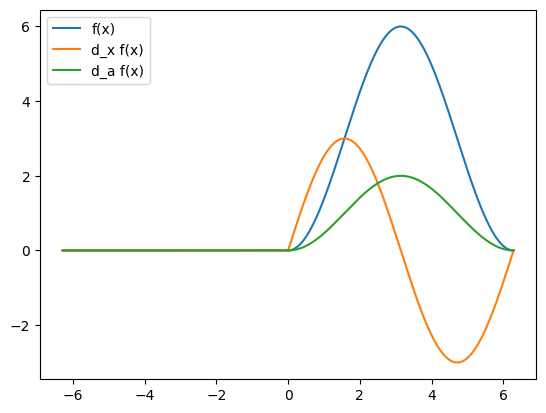

In [31]:
def relu(x):
  return jnp.maximum(0, x)

def theta(x):
  return (x > 0)

def f(x, a):
  return a * (1 - jnp.cos(x)) * theta(x)

a = 3.0
xs = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 10000)

# Vmapping time save test:
start_time = time.time()
ys = []
for x in xs:
  ys.append(f(x, a))
ys = jnp.array(ys)
end_time = time.time()
print("Loop time: ", end_time - start_time)

start_time = time.time()

# vmap(f) is a new function with the same signature as f.
# vmap(f, in_axes = (0, None)) means we only want to vectorize over the first argument (x), not the second.

ys = vmap(f, in_axes = (0, None))(xs, a)
end_time = time.time()
print("Vmap time: ", end_time - start_time)


# Compile the function
start_time = time.time()
f_jit = jit(f)
f_jit(0, a).block_until_ready() # Need to run the compiled function once to compile "just in time"
end_time = time.time()
print("Compilation time: ", end_time - start_time)
# Note that compilation is NOT always faster, especially for only simple functions.


start_time = time.time()
ys = []
for x in xs:
  ys.append(f_jit(x, a))
ys = jnp.array(ys)
end_time = time.time()
print("JIT loop time: ", end_time - start_time)

start_time = time.time()
ys = vmap(f_jit, in_axes=(0, None))(xs, a)
end_time = time.time()
print("JIT vmap time: ", end_time - start_time)



# Get the exact gradient with respect to x
f_prime = jax.grad(f)
f_prime_jit = jit(f_prime)
f_prime_jit(0.0, a).block_until_ready() # Need to run the compiled function once to compile "just in time"

# Get the exact gradient with respect to a
f_prime_a = jax.grad(f, argnums=1) # Argnums is the argument we want the gradient of.
f_prime_a_jit = jit(f_prime_a)


plt.plot(xs, vmap(f_jit, in_axes=(0, None))(xs, a), label='f(x)')
plt.plot(xs, vmap(f_prime_jit, in_axes=(0, None))(xs, a), label='d_x f(x)')
plt.plot(xs, vmap(f_prime_a_jit, in_axes=(0, None))(xs, a), label='d_a f(x)')
plt.legend()
plt.show()



##Chapter 2.2: End-to-End MLP and Training from Scratch

TODO: TEXT

In [34]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X, y = make_moons(1024, noise=0.15, random_state=0)
X = StandardScaler().fit_transform(X)
X = jnp.array(X);  y = jnp.array(y)

key = random.PRNGKey(0)
key, sub = random.split(key)
w = random.normal(sub, (2,)) * 0.1
b = 0.0
params = (w, b)

def model(p, x): w, b = p; return jnp.dot(x, w) + b
def loss(p, x, y):
    logits = model(p, x)
    return -jnp.mean(y*jax.nn.log_sigmoid(logits) + (1-y)*jax.nn.log_sigmoid(-logits))

@jit
def step(p, x, y, lr=0.2):
    g = grad(loss)(p, x, y)
    return jax.tree_util.tree_map(lambda a,b: a-lr*b, p, g)

for _ in range(200):
    params = step(params, X, y)

print("Final loss:", loss(params, X, y))

Final loss: 0.28135824


TODO: TEXT

In [35]:

def init_mlp(sizes, key, scale=0.1):
    keys = random.split(key, len(sizes)-1)
    return [(random.normal(k1, (m,n))*scale, jnp.zeros(n))
            for k1,(m,n) in zip(keys, zip(sizes[:-1], sizes[1:]))]

def apply_mlp(params, x):
    *hidden, (wL,bL) = params
    for w,b in hidden: x = jax.nn.relu(jnp.dot(x,w)+b)
    return jnp.dot(x,wL)+bL

layer_sizes = [2,32,32,1]
key, sub = random.split(key)
params = init_mlp(layer_sizes, sub)

def loss(p,x,y):
    logits = jnp.squeeze(apply_mlp(p,x))
    return -jnp.mean(y*jax.nn.log_sigmoid(logits)+(1-y)*jax.nn.log_sigmoid(-logits))

@jit
def step(p,x,y,lr=0.05):
    g = grad(loss)(p,x,y)
    return [(w-lr*gw, b-lr*gb) for (w,b),(gw,gb) in zip(p,g)]

for _ in range(500):
    params = step(params,X,y)

print("MLP loss:", loss(params,X,y))


MLP loss: 0.26908526


## Chapter 2.3: Using Prebuilt ML Modules

In [37]:

from jax.example_libraries import stax
init, apply = stax.serial(
    stax.Dense(32), stax.Relu,
    stax.Dense(32), stax.Relu,
    stax.Dense(1)
)
key, sub = random.split(key)
_, p = init(sub, (-1,2))

def loss(p,x,y):
    logits = jnp.squeeze(apply(p,x))
    return -jnp.mean(y*jax.nn.log_sigmoid(logits)+(1-y)*jax.nn.log_sigmoid(-logits))

@jit
def step(p,x,y,lr=0.05):
    g = grad(loss)(p,x,y)
    return jax.tree_util.tree_map(lambda a,b: a-lr*b, p, g)

for _ in range(300):
    p = step(p,X,y)

print("stax loss:", loss(p,X,y))


stax loss: 0.25320753


#Chapter 3: PyTorch

In [38]:

import torch, torch.nn as nn
device='cuda' if torch.cuda.is_available() else 'cpu'

X_t = torch.tensor(X, dtype=torch.float32).to(device)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

model = nn.Sequential(
    nn.Linear(2,32), nn.ReLU(),
    nn.Linear(32,32), nn.ReLU(),
    nn.Linear(32,1)
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.BCEWithLogitsLoss()

for _ in range(300):
    opt.zero_grad()
    loss = loss_fn(model(X_t), y_t)
    loss.backward()
    opt.step()

print("PyTorch loss:", loss.item())


PyTorch loss: 0.021121950820088387


# Chapter 4: Tensorflow

TODO: TALK ABOUT KERAS/TF SPLIT

In [ ]:

import tensorflow as tf
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
y_tf = tf.expand_dims(tf.convert_to_tensor(y, dtype=tf.float32),1)

model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])
model_tf.fit(X_tf, y_tf, epochs=300, verbose=0)
print("TF loss, acc:", model_tf.evaluate(X_tf, y_tf, verbose=0))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
